In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import celltypist

In [2]:
# import session_info
# session_info.show()

In [3]:
sc.settings.set_figure_params(dpi=80)

# Variables

In [4]:
adata_dir = '/lustre/scratch126/cellgen/team205/kk18/VisiumHD/objects'
sample_id = 'HEA_FOET14880396'

In [5]:
os.getcwd()

'/nfs/team205/kk18/notebooks/Foetal/VisiumHD/re-seq_mpp0p3'

# Read in data

In [6]:
adata = sc.read_h5ad(f'{adata_dir}/{sample_id}_b2c_cells_filtered.h5ad')
adata

AnnData object with n_obs × n_vars = 129803 × 18047
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

# Normalise the counts

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [8]:
adata.X.data[:5]

array([1.27187559, 1.95641568, 1.75023687, 1.96760567, 2.7810601 ])

# UMAP

In [9]:
# sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

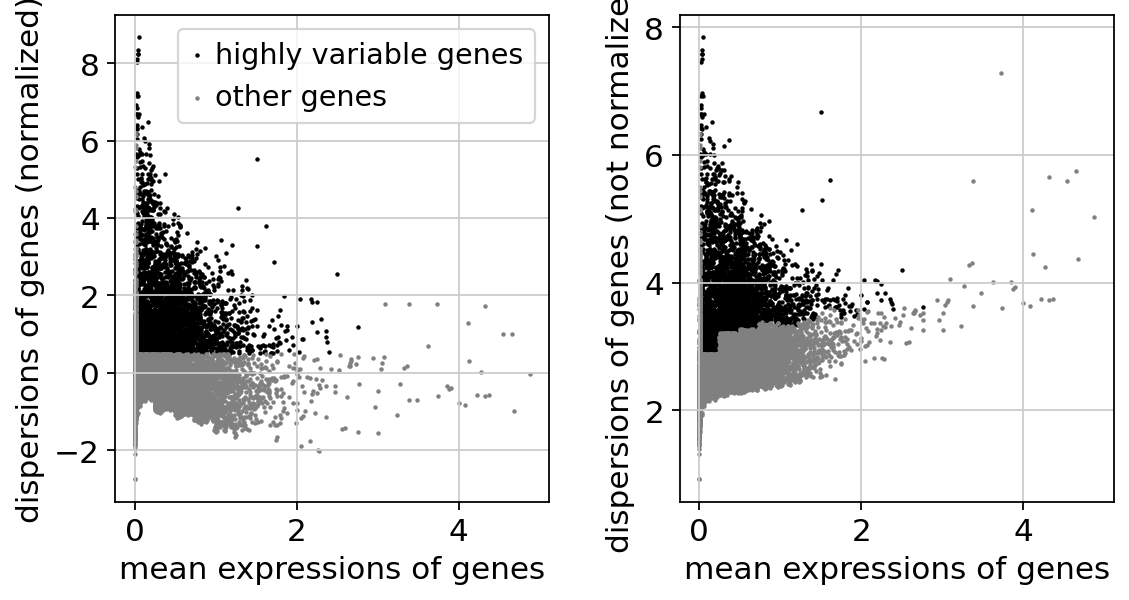

number of hvgs: 3066


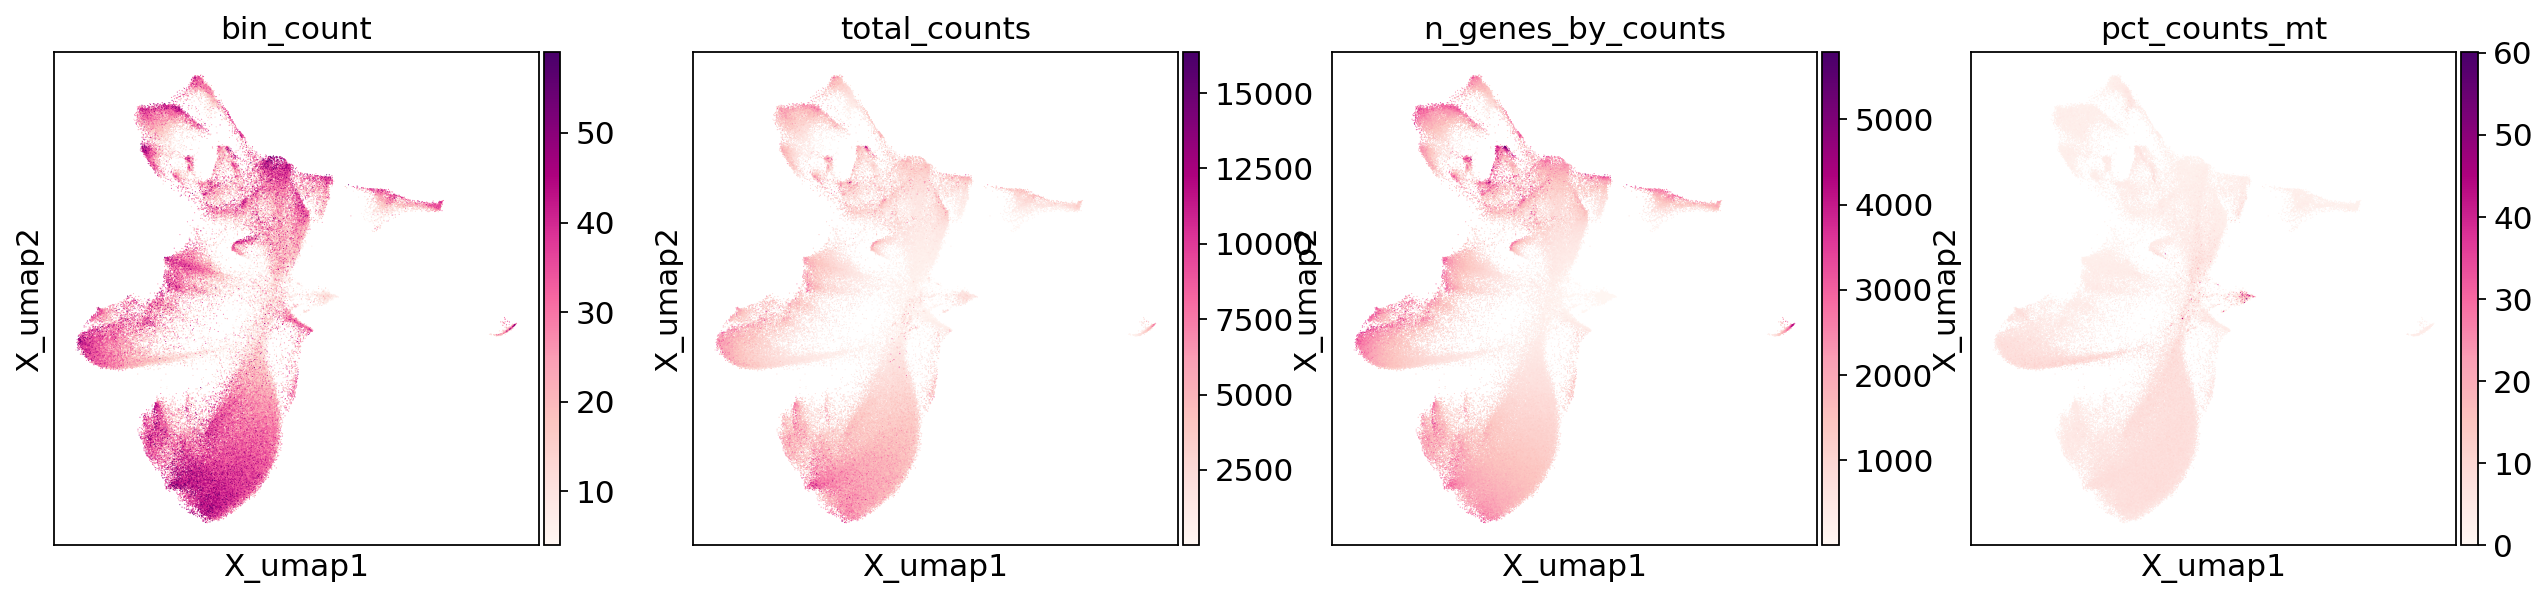

In [10]:
# HVGs
sc.pp.highly_variable_genes(adata, flavor='seurat', min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
print(f'number of hvgs: {sum(adata.var.highly_variable)}')
# PCA
sc.tl.pca(adata, use_highly_variable=True)
# create neighbour graph
sc.pp.neighbors(adata,n_neighbors=15,use_rep='X_pca')
# visualisation with umap
sc.tl.umap(adata,min_dist=0.2)
sc.pl.embedding(adata,basis='X_umap',color=['bin_count','total_counts','n_genes_by_counts',"pct_counts_mt"],wspace=0.2,cmap='RdPu',vmax='p100')

# CellTypist prediction: coarse-grain

In [11]:
# coarse-grained
predictions = celltypist.annotate(adata, 
                                  model = '/nfs/team205/kk18/notebooks/Foetal/VisiumHD/mpp0p3/celltypist_models/from_foetal_portal/foetal_heart_coarse.pkl', 
                                  majority_voting = False)

# add to anndata
adata = predictions.to_adata(insert_labels = True, insert_conf = True)
adata.obs.rename(columns={'predicted_labels':'celltypist_coarse',
                              'conf_score':'conf_score_coarse'
                             },inplace=True)
adata.obs.head()

🔬 Input data has 129803 cells and 18047 genes
🔗 Matching reference genes in the model
🧬 17059 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


,object_id,bin_count,array_row,array_col,labels_joint_source,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,celltypist_coarse,conf_score_coarse
1,1,31,2932.612903,334.000000,primary,1392,7.239215,2143.185571,7.670515,18.289668,26.849281,41.065265,65.639095,38.493123,3.676127,1.796070,Leukocytes,0.997673
2,2,26,2959.346154,336.923077,primary,1676,7.424762,2746.897101,7.918591,14.834485,22.314441,33.760200,56.404559,112.431845,4.731202,4.093049,Leukocytes,0.918246
3,3,31,2882.451613,334.193548,primary,1901,7.550661,3495.787525,8.159600,19.890413,28.352137,41.257376,63.262729,90.328581,4.514464,2.583927,Leukocytes,0.999999
4,4,28,2862.250000,515.178571,primary,1972,7.587311,3331.427722,8.111456,19.251407,25.541944,35.450216,56.840294,30.990229,3.465431,0.930239,Leukocytes,0.002559
5,5,35,2870.714286,305.171429,primary,811,6.699500,6227.605806,8.736908,30.681559,42.083621,57.300205,85.421432,113.386240,4.739581,1.820704,Mesenchymal,0.999998


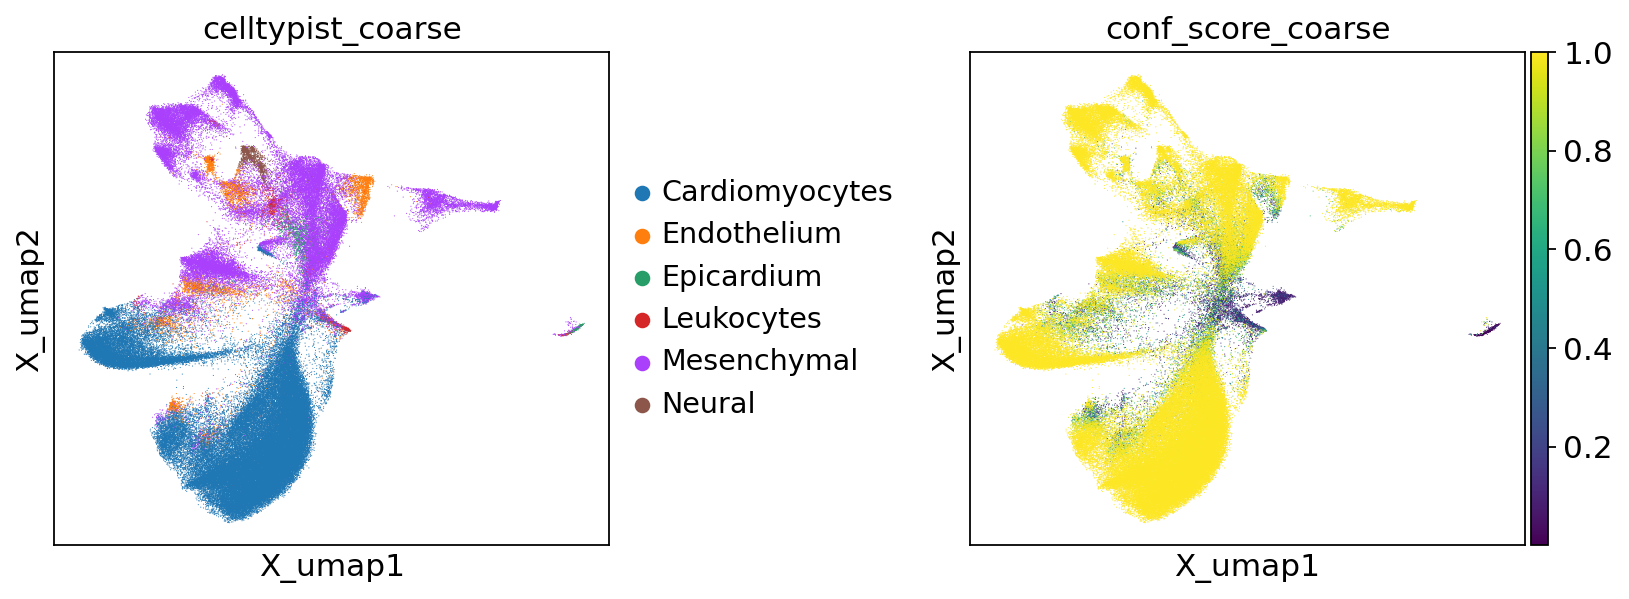

In [12]:
sc.pl.embedding(adata,
                    basis=f"X_umap",
                    color=['celltypist_coarse','conf_score_coarse'],
                   ncols=4,wspace=0.5
                   )

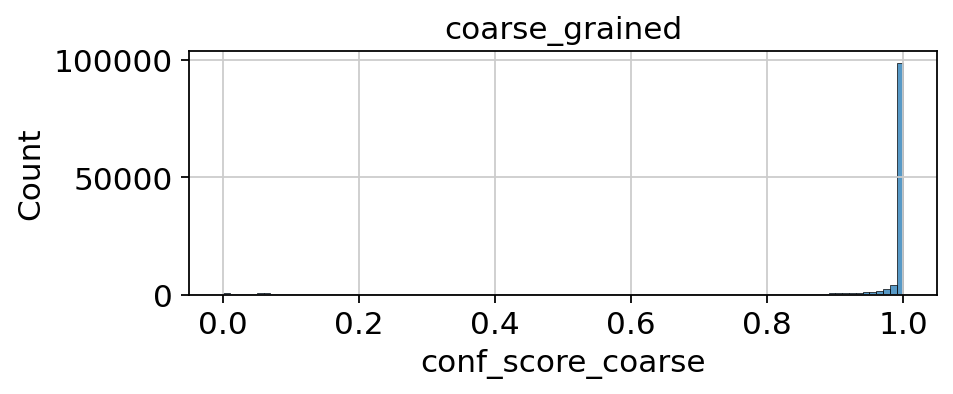

In [13]:
# celltypist confidence
plt.figure(figsize=(6, 2))
sns.histplot(adata.obs[f'conf_score_coarse'], kde=False, bins=100)
# plt.yscale('log')
plt.title('coarse_grained')
plt.show()

In [14]:
# check
conf_thresh = 0.5 # starting from relaxed threshold
pd.crosstab(adata.obs['celltypist_coarse'],adata.obs[f'conf_score_coarse']<conf_thresh)

conf_score_coarse,False,True
celltypist_coarse,,
Cardiomyocytes,76088,2953
Endothelium,4380,1205
Epicardium,603,718
Leukocytes,626,681
Mesenchymal,36370,4812
Neural,1254,113


In [15]:
# finalised coarse-grained labels
conf_thresh = 0.5
adata.obs['celltypist_coarse_fin'] = adata.obs['celltypist_coarse'].astype('str').copy()
low_quality_cells = adata.obs_names[adata.obs[f'conf_score_coarse']<conf_thresh]
adata.obs.loc[low_quality_cells,'celltypist_coarse_fin'] = 'unassigned'
adata.obs['celltypist_coarse_fin'].value_counts()

celltypist_coarse_fin
Cardiomyocytes    76088
Mesenchymal       36370
unassigned        10482
Endothelium        4380
Neural             1254
Leukocytes          626
Epicardium          603
Name: count, dtype: int64

... storing 'celltypist_coarse_fin' as categorical


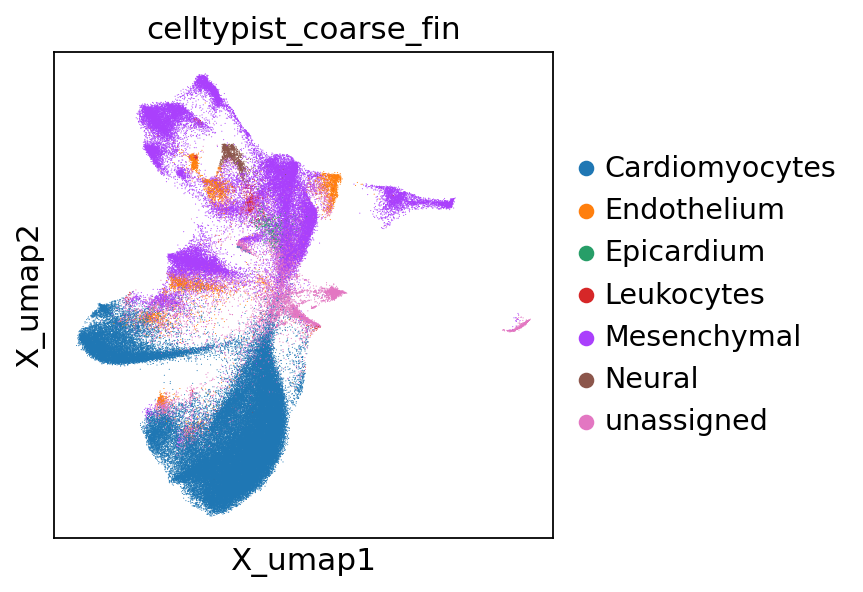

In [16]:
sc.pl.embedding(adata,
                    basis=f"X_umap",
                    color=['celltypist_coarse_fin'],
                   ncols=4,wspace=0.5
                   )

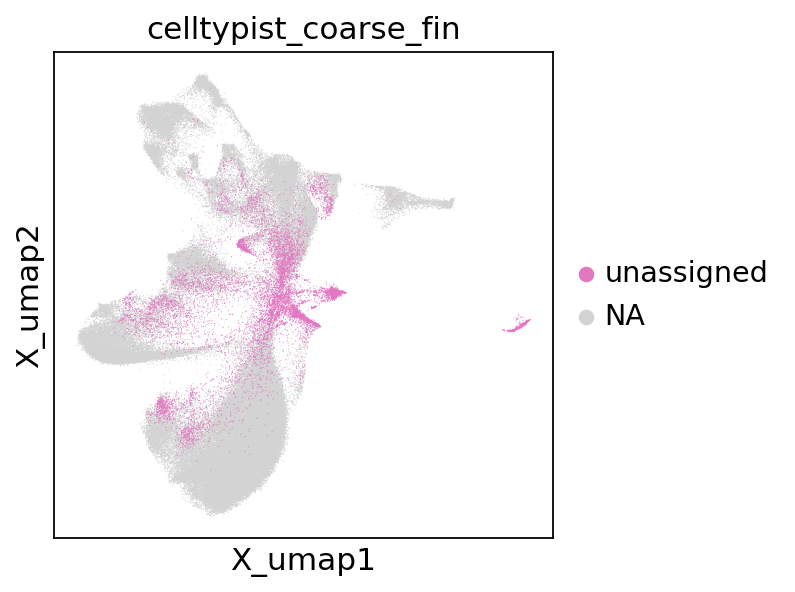

In [17]:
sc.pl.embedding(adata,
                    basis=f"X_umap",
                    color=['celltypist_coarse_fin'],groups='unassigned',
                   ncols=4,wspace=0.5
                   )

# CellTypist prediction: mid-grain

In [18]:
adata.obs['celltypist_coarse2midmod'] = np.nan
adata.obs['conf_score_coarse2midmod'] = np.nan

for celltype in adata.obs['celltypist_coarse_fin'].unique():
    if celltype not in ['unassigned', 'Epicardium']: # 'Epicardium' is also 'Epicardium' in mid-grained
        print(celltype)
        # subset
        adata_sub = adata[adata.obs['celltypist_coarse_fin']==celltype]
        # predict
        predictions = celltypist.annotate(adata_sub, 
                                      model = f'/nfs/team205/kk18/notebooks/Foetal/VisiumHD/mpp0p3/celltypist_models/coarse2midmod_{celltype}.pkl', 
                                      majority_voting = False)
        # add to anndata
        adata_sub = predictions.to_adata(insert_labels = True, insert_conf = True)
        adata.obs.loc[adata_sub.obs_names,'celltypist_coarse2midmod'] = adata_sub.obs['predicted_labels']
        adata.obs.loc[adata_sub.obs_names,'conf_score_coarse2midmod'] = adata_sub.obs['conf_score']
        print('')

Leukocytes


🔬 Input data has 626 cells and 18047 genes
🔗 Matching reference genes in the model
🧬 16956 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!



Mesenchymal


🔬 Input data has 36370 cells and 18047 genes
🔗 Matching reference genes in the model
🧬 17166 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!



Endothelium


🔬 Input data has 4380 cells and 18047 genes
🔗 Matching reference genes in the model
🧬 16989 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!



Neural


🔬 Input data has 1254 cells and 18047 genes
🔗 Matching reference genes in the model
🧬 16779 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!



Cardiomyocytes


🔬 Input data has 76088 cells and 18047 genes
🔗 Matching reference genes in the model
🧬 16534 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


... storing 'celltypist_coarse2midmod' as categorical


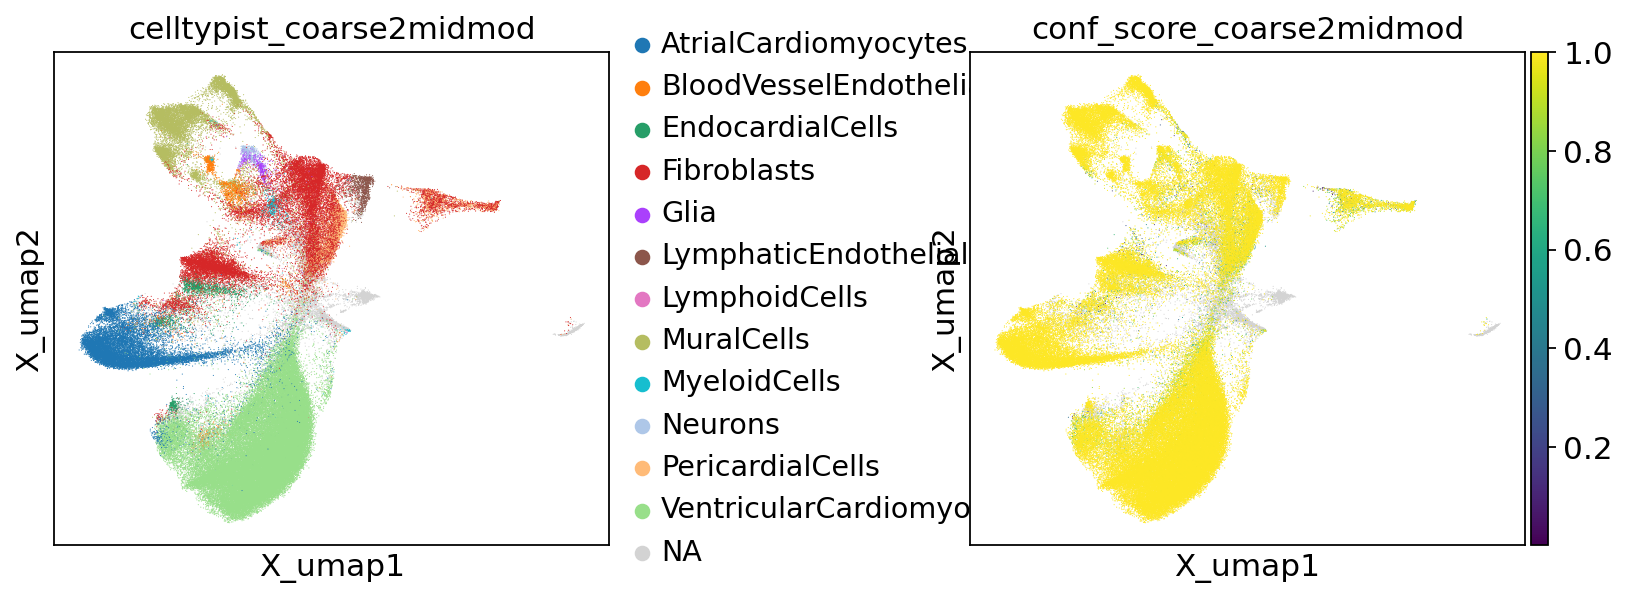

In [19]:
sc.pl.embedding(adata,
                    basis=f"X_umap",
                    color=['celltypist_coarse2midmod','conf_score_coarse2midmod'],
                   ncols=4,wspace=0.5
                   )

In [20]:
# check
conf_thresh = 0.8
pd.crosstab(adata.obs['celltypist_coarse2midmod'],adata.obs[f'conf_score_coarse2midmod']<conf_thresh)

conf_score_coarse2midmod,False,True
celltypist_coarse2midmod,,
AtrialCardiomyocytes,13904,311
BloodVesselEndothelialCells,1765,31
EndocardialCells,1526,30
Fibroblasts,20318,1103
Glia,588,35
LymphaticEndothelialCells,1025,3
LymphoidCells,87,6
MuralCells,10785,440
MyeloidCells,526,7


In [21]:
# finalised mid-grained labels
conf_thresh = 0.8
adata.obs['celltypist_mid_fin'] = adata.obs['celltypist_coarse_fin'].astype('str').copy()
adata.obs.replace({'celltypist_mid_fin':{'Epicardium':'EpicardialCells'}},inplace=True)
passed = adata.obs_names[adata.obs['conf_score_coarse2midmod']>=conf_thresh]
low_quality_cells = adata.obs_names[adata.obs[f'conf_score_coarse2midmod']<conf_thresh]

adata.obs.loc[passed,'celltypist_mid_fin'] = adata.obs.loc[passed,'celltypist_coarse2midmod'].copy()
adata.obs.loc[low_quality_cells,'celltypist_mid_fin'] = 'unassigned'
adata.obs['celltypist_mid_fin'].value_counts()

celltypist_mid_fin
VentricularCardiomyocytes      61075
Fibroblasts                    20318
unassigned                     13951
AtrialCardiomyocytes           13904
MuralCells                     10785
PericardialCells                3061
BloodVesselEndothelialCells     1765
EndocardialCells                1526
LymphaticEndothelialCells       1025
EpicardialCells                  603
Neurons                          589
Glia                             588
MyeloidCells                     526
LymphoidCells                     87
Name: count, dtype: int64

... storing 'celltypist_mid_fin' as categorical


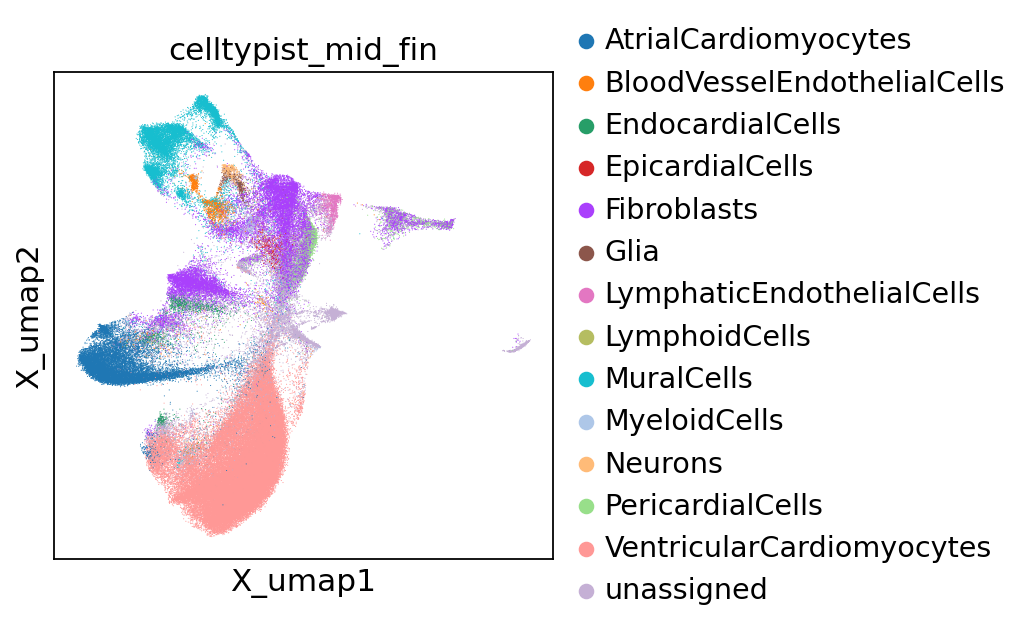

In [22]:
sc.pl.embedding(adata,
                    basis=f"X_umap",
                    color=['celltypist_mid_fin'],
                   ncols=4,wspace=0.5
                   )

# celltypist prediction: fine-grain

In [23]:
adata.obs['celltypist_midmod2fine'] = np.nan
adata.obs['conf_score_midmod2fine'] = np.nan

for celltype in adata.obs['celltypist_mid_fin'].unique():
    if celltype not in ['unassigned', 'LymphaticEndothelialCells']: # 'LymphaticEndothelialCells' is also 'LymphaticEndothelialCells' in fine-grained
        print(celltype)
        # subset
        adata_sub = adata[adata.obs['celltypist_mid_fin']==celltype]
        # predict
        predictions = celltypist.annotate(adata_sub, 
                                      model = f'/nfs/team205/kk18/notebooks/Foetal/VisiumHD/mpp0p3/celltypist_models/midmod2fine_{celltype}.pkl', 
                                      majority_voting = False)
        # add to anndata
        adata_sub = predictions.to_adata(insert_labels = True, insert_conf = True)
        adata.obs.loc[adata_sub.obs_names,'celltypist_midmod2fine'] = adata_sub.obs['predicted_labels']
        adata.obs.loc[adata_sub.obs_names,'conf_score_midmod2fine'] = adata_sub.obs['conf_score']
        print('')

LymphoidCells


🔬 Input data has 87 cells and 18047 genes
🔗 Matching reference genes in the model
🧬 17008 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!



MyeloidCells


🔬 Input data has 526 cells and 18047 genes
🔗 Matching reference genes in the model
🧬 17087 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!



Fibroblasts


🔬 Input data has 20318 cells and 18047 genes
🔗 Matching reference genes in the model
🧬 17022 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!



PericardialCells


🔬 Input data has 3061 cells and 18047 genes
🔗 Matching reference genes in the model
🧬 16563 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!



BloodVesselEndothelialCells


🔬 Input data has 1765 cells and 18047 genes
🔗 Matching reference genes in the model
🧬 16931 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!



MuralCells


🔬 Input data has 10785 cells and 18047 genes
🔗 Matching reference genes in the model
🧬 16683 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!



Neurons


🔬 Input data has 589 cells and 18047 genes
🔗 Matching reference genes in the model
🧬 16254 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!



Glia


🔬 Input data has 588 cells and 18047 genes
🔗 Matching reference genes in the model
🧬 16388 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!



EpicardialCells


🔬 Input data has 603 cells and 18047 genes
🔗 Matching reference genes in the model
🧬 16982 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!



AtrialCardiomyocytes


🔬 Input data has 13904 cells and 18047 genes
🔗 Matching reference genes in the model
🧬 16481 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!



EndocardialCells


🔬 Input data has 1526 cells and 18047 genes
🔗 Matching reference genes in the model
🧬 16303 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!



VentricularCardiomyocytes


🔬 Input data has 61075 cells and 18047 genes
🔗 Matching reference genes in the model
🧬 16613 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


... storing 'celltypist_midmod2fine' as categorical


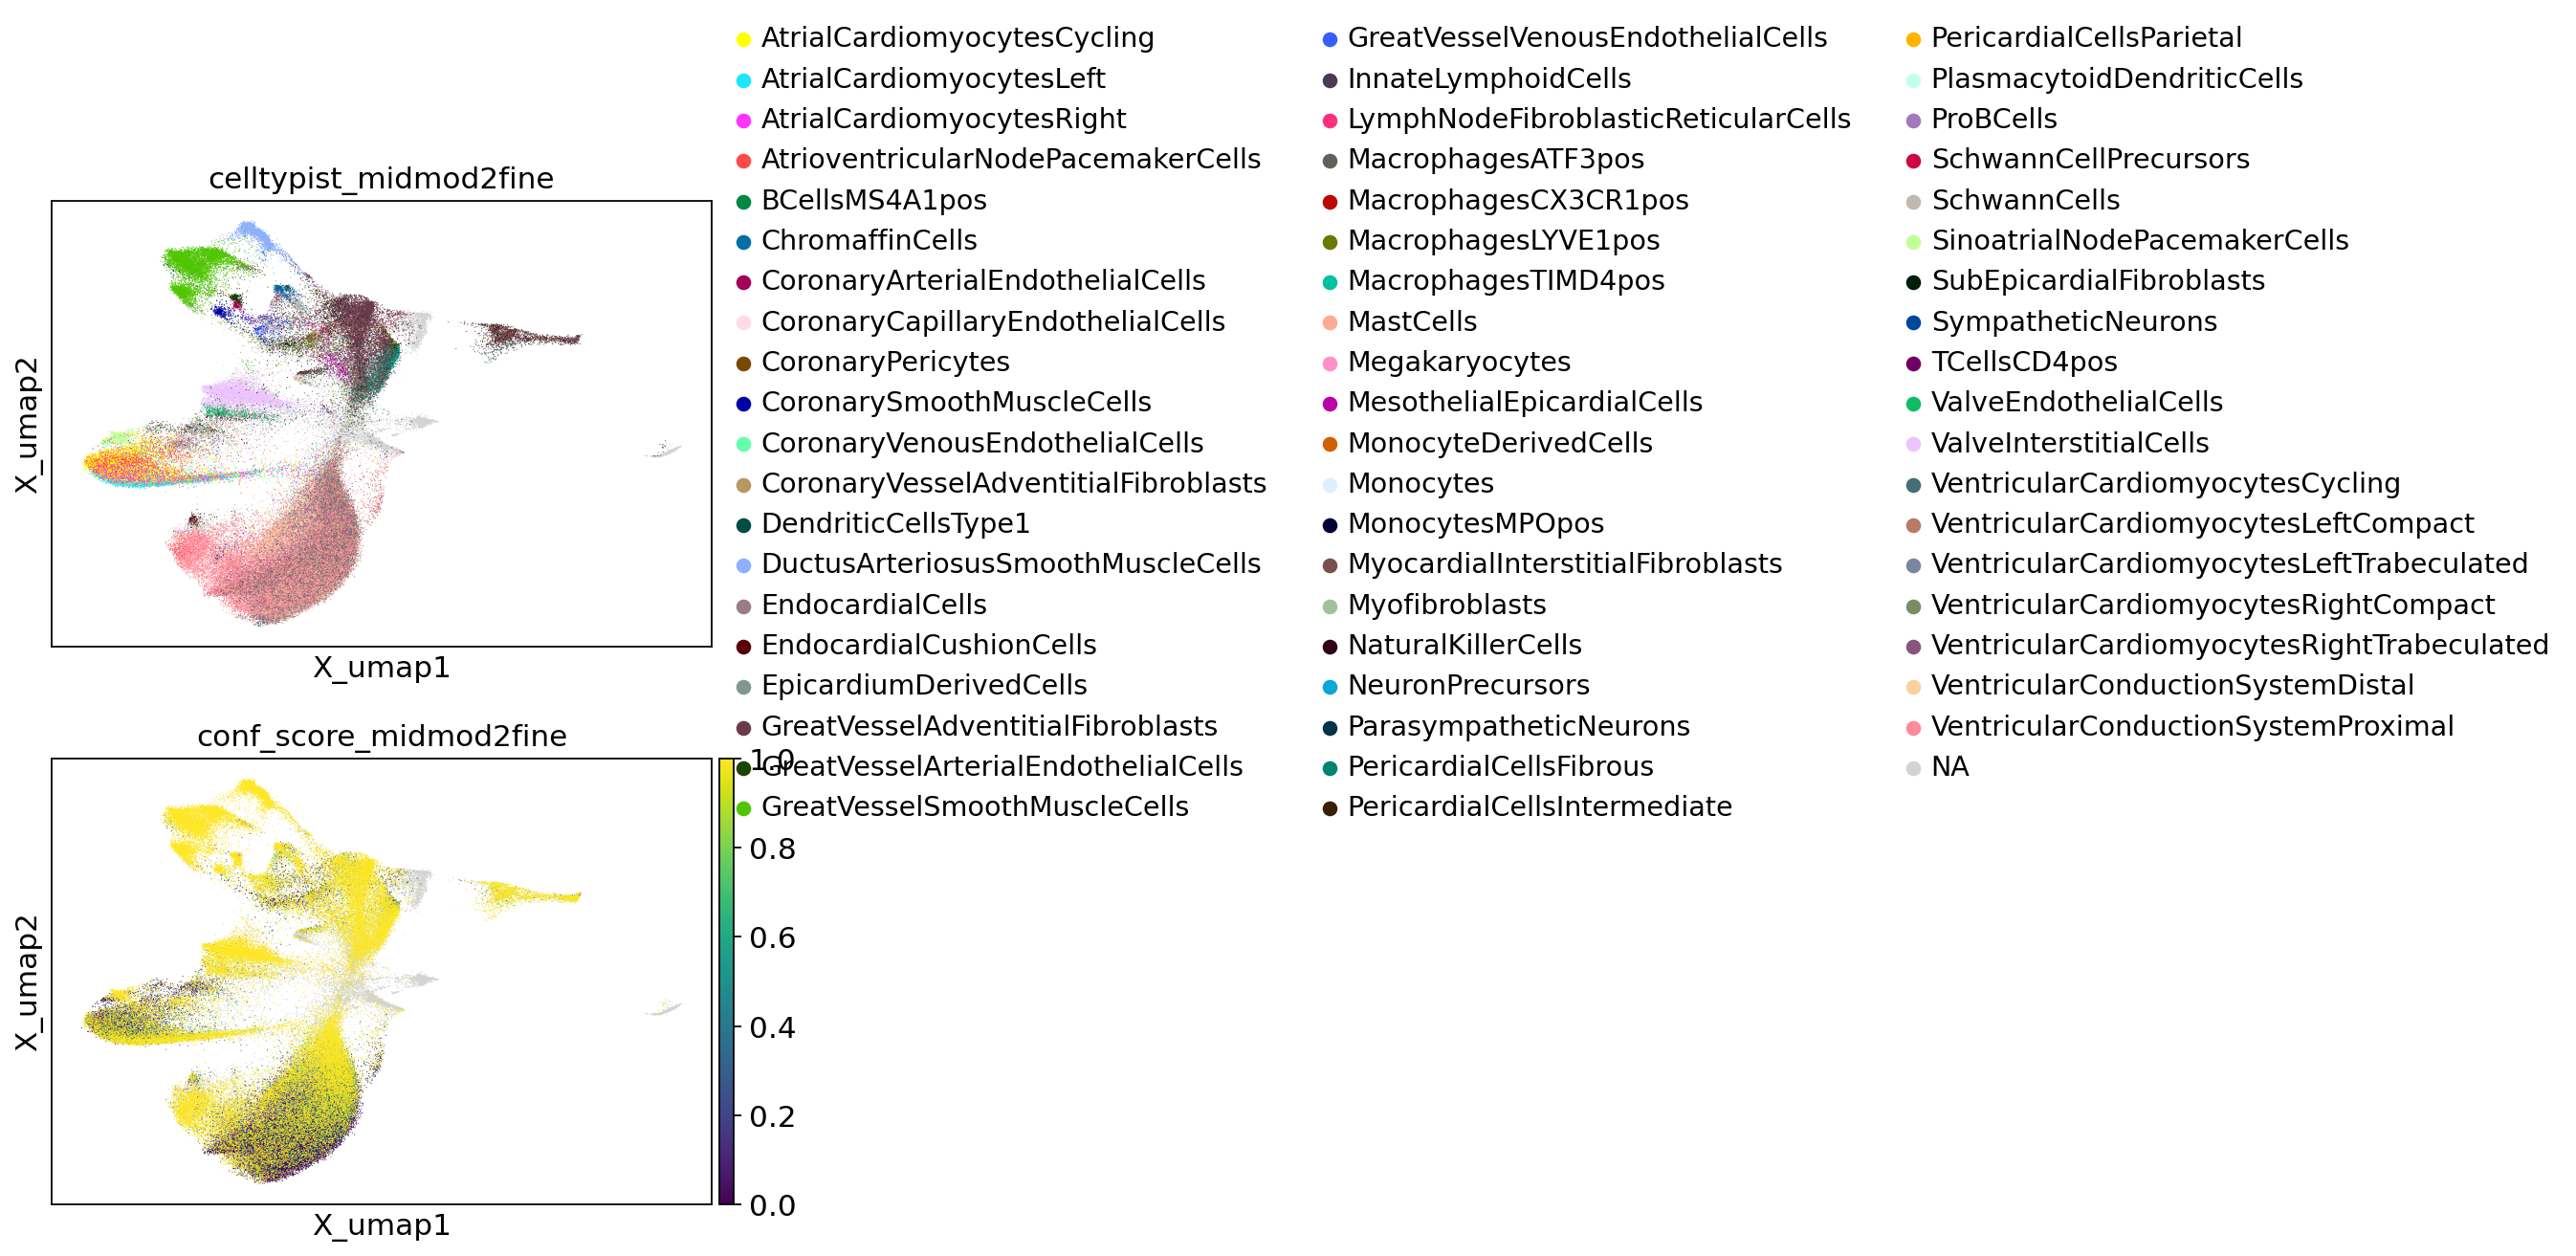

In [24]:
sc.pl.embedding(adata,
                    basis=f"X_umap",
                    color=['celltypist_midmod2fine','conf_score_midmod2fine'],
                   ncols=1,wspace=0.5
                   )

# Save

In [25]:
adata.write(f'{adata_dir}/{sample_id}_b2c_cells_filtered_lognorm.h5ad')
adata

AnnData object with n_obs × n_vars = 129803 × 18047
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'celltypist_coarse_colors', 'celltypist_coarse_fin_colors', 'celltypist_coarse2midmod_c

In [26]:
print(f'{adata_dir}/{sample_id}_b2c_cells_filtered_lognorm.h5ad')

/lustre/scratch126/cellgen/team205/kk18/VisiumHD/objects/HEA_FOET14880396_b2c_cells_filtered_lognorm.h5ad
